<a href="https://colab.research.google.com/github/aditi-saxena-1206/Face-Exp-Recognition/blob/main/face_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# importing required libraries
import sys
import os
import numpy as np 
import pandas as pd 


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint

#load dataset
df = pd.read_csv("/content/drive/MyDrive/Expression recognition/needed/fer2013.csv")

#data visualization
print(df.info())
print(df.columns)
print(df.head())
print(df.Usage.unique())

#data splitting
X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []

for index,row in df.iterrows():
    pix = row['pixels'].split(' ')
    if row['Usage'] == 'Training':
        X_train.append(np.array(pix,'float32'))
        Y_train.append(row['emotion'])
    elif row['Usage'] == "PublicTest":
        X_val.append(np.array(pix,'float32'))
        Y_val.append(row['emotion'])
    elif row['Usage'] == "PrivateTest":
        X_test.append(np.array(pix,'float32'))
        Y_test.append(row['emotion'])

#print(X_train)
X_train = np.array(X_train,'float32')
Y_train = np.array(Y_train,'float32')
X_val = np.array(X_val,'float32')
Y_val = np.array(Y_val,'float32')
X_test = np.array(X_test,'float32')
Y_test = np.array(Y_test,'float32')

print(X_train.shape)

Y_train = np_utils.to_categorical(Y_train, num_classes=7)
Y_test = np_utils.to_categorical(Y_test, num_classes=7)
Y_val = np_utils.to_categorical(Y_val, num_classes=7)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

print(X_train.shape)

#CNN model

model = Sequential()

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (48,48,1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64,kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7,activation='softmax'))

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Expression recognition/needed/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

model.compile(loss = categorical_crossentropy, optimizer=Adam(lr=0.001), metrics=['accuracy'] )

print("Training model")
model.fit(X_train, Y_train, batch_size=64, epochs = 50, verbose=1, validation_data=(X_val,Y_val), shuffle = True, callbacks=[lr_reducer, checkpointer, early_stopper] )


model_json = model.to_json()
with open("model.json",'w') as json_file:
    json_file.write(model_json)
print("Model saved")
model.save_weights("weights.h5")
print("Weights saved")

Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=-1)
#Y_test = Y_test.to_numpy()
Y_test.flatten()
Y_test.shape
from sklearn.metrics import accuracy_score
Y_pred = np_utils.to_categorical(Y_pred, num_classes=7)
print(accuracy_score(Y_test, Y_pred))

KeyboardInterrupt: ignored

In [38]:
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform

def random_rotation(image_array):
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(img):
    '''noise_img = sk.util.random_noise(image_array,var=0.1**2)
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    return noise_img'''
    #print("noisy")
    mean = 2.0   # some constant
    std = 5.0   # some constant (standard deviation)
    noisy_img = img + np.random.normal(mean, std, img.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    return noisy_img_clipped

def horizontal_flip(image_array):
    return image_array[:, ::-1]

def sheared(image_array):
  tf = AffineTransform(shear=-0.2)
  sheared = transform.warp(image_array, tf, order=1, preserve_range=True, mode='wrap')
  return sheared

In [39]:
#model 2 - no validation data
# importing required libraries
import sys
import os
import numpy as np 
import pandas as pd 


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint

#load dataset
df = pd.read_csv("/content/drive/MyDrive/Expression recognition/needed/fer2013.csv")

#data visualization
print(df.info())
print(df.columns)
print(df.head())
print(df.Usage.unique())
temp = df[df['Usage'] != 'PrivateTest']
print(temp['emotion'].value_counts())

Y_df = temp['emotion']


#data splitting
X_train = []
Y_train = []
X_test = []
Y_test = []

for index,row in df.iterrows():
    pix = row['pixels'].split(' ')
    if row['Usage'] == 'PrivateTest':
        X_test.append(np.array(pix,'float32'))
        Y_test.append(row['emotion'])
    else:
        X_train.append(np.array(pix,'float32'))
        Y_train.append(row['emotion'])

#print(X_train)
X_train = np.array(X_train,'float32')
Y_train = np.array(Y_train,'float32')
X_test = np.array(X_test,'float32')
Y_test = np.array(Y_test,'float32')

print(X_train.shape)


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

print(X_train.shape)
print(Y_train.shape)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None
Index(['emotion', 'pixels', 'Usage'], dtype='object')
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
['Training' 'PublicTest' 'PrivateTest']
3    8110
6    5572
4    5483
2    4593
0    4462
5    3586
1     492
Name: emotion, dtype: int64
(32298, 2304)
(32298, 48, 

<class 'numpy.ndarray'>


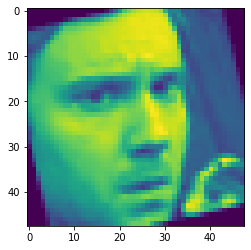

In [24]:
#data augmentation
import random
import cv2
test_image = X_train[0].reshape(48,48)
plt.imshow(test_image)

transdict = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip,
    'sheared' : sheared
    }

transformed_image = None
key = random.choice(list(transdict))
transformed_image = transdict[key](test_image)
transformed_image = cv2.resize(transformed_image, (48,48))
print(type(transformed_image))
plt.imshow(transformed_image)

In [40]:
index2 = Y_df[Y_df == 2].index
index0 = Y_df[Y_df == 0].index
index5 = Y_df[Y_df == 5].index
index1 = Y_df[Y_df == 1].index
for i in index2:
  x = X_train[i].reshape(48,48)
  transformed_image = None
  key = random.choice(list(transdict))
  transformed_image = transdict[key](test_image)
  transformed_image = cv2.resize(transformed_image, (48,48))
  final_img = transformed_image.reshape(1,48,48,1)
  X_train = np.append(X_train,final_img,axis=0)

  print(X_train.shape)

Streaming output truncated to the last 5000 lines.
(32858, 48, 48, 1)
(32859, 48, 48, 1)
noisy
(32860, 48, 48, 1)
(32861, 48, 48, 1)
(32862, 48, 48, 1)
(32863, 48, 48, 1)
(32864, 48, 48, 1)
(32865, 48, 48, 1)
(32866, 48, 48, 1)
(32867, 48, 48, 1)
(32868, 48, 48, 1)
(32869, 48, 48, 1)
(32870, 48, 48, 1)
(32871, 48, 48, 1)
(32872, 48, 48, 1)
(32873, 48, 48, 1)
noisy
(32874, 48, 48, 1)
(32875, 48, 48, 1)
noisy
(32876, 48, 48, 1)
(32877, 48, 48, 1)
(32878, 48, 48, 1)
(32879, 48, 48, 1)
noisy
(32880, 48, 48, 1)
(32881, 48, 48, 1)
(32882, 48, 48, 1)
(32883, 48, 48, 1)
(32884, 48, 48, 1)
(32885, 48, 48, 1)
(32886, 48, 48, 1)
(32887, 48, 48, 1)
(32888, 48, 48, 1)
(32889, 48, 48, 1)
(32890, 48, 48, 1)
(32891, 48, 48, 1)
(32892, 48, 48, 1)
(32893, 48, 48, 1)
noisy
(32894, 48, 48, 1)
(32895, 48, 48, 1)
(32896, 48, 48, 1)
(32897, 48, 48, 1)
noisy
(32898, 48, 48, 1)
(32899, 48, 48, 1)
(32900, 48, 48, 1)
(32901, 48, 48, 1)
noisy
(32902, 48, 48, 1)
noisy
(32903, 48, 48, 1)
noisy
(32904, 48, 48, 1)
(3

In [41]:
for i in index0:
  x = X_train[i].reshape(48,48)
  transformed_image = None
  key = random.choice(list(transdict))
  transformed_image = transdict[key](test_image)
  transformed_image = cv2.resize(transformed_image, (48,48))
  final_img = transformed_image.reshape(1,48,48,1)
  X_train = np.append(X_train,final_img,axis=0)
  print(X_train.shape)

Streaming output truncated to the last 5000 lines.
(37339, 48, 48, 1)
(37340, 48, 48, 1)
noisy
(37341, 48, 48, 1)
(37342, 48, 48, 1)
(37343, 48, 48, 1)
(37344, 48, 48, 1)
(37345, 48, 48, 1)
noisy
(37346, 48, 48, 1)
noisy
(37347, 48, 48, 1)
(37348, 48, 48, 1)
noisy
(37349, 48, 48, 1)
(37350, 48, 48, 1)
(37351, 48, 48, 1)
(37352, 48, 48, 1)
noisy
(37353, 48, 48, 1)
(37354, 48, 48, 1)
(37355, 48, 48, 1)
(37356, 48, 48, 1)
(37357, 48, 48, 1)
noisy
(37358, 48, 48, 1)
(37359, 48, 48, 1)
(37360, 48, 48, 1)
(37361, 48, 48, 1)
(37362, 48, 48, 1)
(37363, 48, 48, 1)
(37364, 48, 48, 1)
(37365, 48, 48, 1)
(37366, 48, 48, 1)
noisy
(37367, 48, 48, 1)
(37368, 48, 48, 1)
(37369, 48, 48, 1)
noisy
(37370, 48, 48, 1)
(37371, 48, 48, 1)
noisy
(37372, 48, 48, 1)
noisy
(37373, 48, 48, 1)
(37374, 48, 48, 1)
(37375, 48, 48, 1)
noisy
(37376, 48, 48, 1)
(37377, 48, 48, 1)
noisy
(37378, 48, 48, 1)
(37379, 48, 48, 1)
(37380, 48, 48, 1)
(37381, 48, 48, 1)
(37382, 48, 48, 1)
noisy
(37383, 48, 48, 1)
(37384, 48, 48, 

In [42]:
for i in index5:
  x = X_train[i].reshape(48,48)
  transformed_image = None
  key = random.choice(list(transdict))
  transformed_image = transdict[key](test_image)
  transformed_image = cv2.resize(transformed_image, (48,48))
  final_img = transformed_image.reshape(1,48,48,1)
  X_train = np.append(X_train,final_img,axis=0)
  print(X_train.shape)

(41354, 48, 48, 1)
(41355, 48, 48, 1)
(41356, 48, 48, 1)
noisy
(41357, 48, 48, 1)
noisy
(41358, 48, 48, 1)
(41359, 48, 48, 1)
(41360, 48, 48, 1)
(41361, 48, 48, 1)
noisy
(41362, 48, 48, 1)
(41363, 48, 48, 1)
(41364, 48, 48, 1)
(41365, 48, 48, 1)
noisy
(41366, 48, 48, 1)
(41367, 48, 48, 1)
(41368, 48, 48, 1)
(41369, 48, 48, 1)
noisy
(41370, 48, 48, 1)
(41371, 48, 48, 1)
noisy
(41372, 48, 48, 1)
(41373, 48, 48, 1)
(41374, 48, 48, 1)
noisy
(41375, 48, 48, 1)
(41376, 48, 48, 1)
noisy
(41377, 48, 48, 1)
(41378, 48, 48, 1)
(41379, 48, 48, 1)
(41380, 48, 48, 1)
(41381, 48, 48, 1)
(41382, 48, 48, 1)
(41383, 48, 48, 1)
(41384, 48, 48, 1)
(41385, 48, 48, 1)
noisy
(41386, 48, 48, 1)
(41387, 48, 48, 1)
(41388, 48, 48, 1)
(41389, 48, 48, 1)
(41390, 48, 48, 1)
noisy
(41391, 48, 48, 1)
(41392, 48, 48, 1)
(41393, 48, 48, 1)
noisy
(41394, 48, 48, 1)
(41395, 48, 48, 1)
(41396, 48, 48, 1)
noisy
(41397, 48, 48, 1)
(41398, 48, 48, 1)
(41399, 48, 48, 1)
(41400, 48, 48, 1)
(41401, 48, 48, 1)
noisy
(41402, 48

In [43]:
for j in range(20):
  for i in index1:
    x = X_train[i].reshape(48,48)
    transformed_image = None
    key = random.choice(list(transdict))
    transformed_image = transdict[key](test_image)
    transformed_image = cv2.resize(transformed_image, (48,48))
    final_img = transformed_image.reshape(1,48,48,1)
    X_train = np.append(X_train,final_img,axis=0)
    print(X_train.shape)

Streaming output truncated to the last 5000 lines.
noisy
(50760, 48, 48, 1)
(50761, 48, 48, 1)
(50762, 48, 48, 1)
(50763, 48, 48, 1)
(50764, 48, 48, 1)
(50765, 48, 48, 1)
(50766, 48, 48, 1)
(50767, 48, 48, 1)
(50768, 48, 48, 1)
(50769, 48, 48, 1)
(50770, 48, 48, 1)
(50771, 48, 48, 1)
(50772, 48, 48, 1)
noisy
(50773, 48, 48, 1)
noisy
(50774, 48, 48, 1)
(50775, 48, 48, 1)
noisy
(50776, 48, 48, 1)
(50777, 48, 48, 1)
(50778, 48, 48, 1)
(50779, 48, 48, 1)
(50780, 48, 48, 1)
(50781, 48, 48, 1)
(50782, 48, 48, 1)
(50783, 48, 48, 1)
(50784, 48, 48, 1)
(50785, 48, 48, 1)
(50786, 48, 48, 1)
(50787, 48, 48, 1)
(50788, 48, 48, 1)
(50789, 48, 48, 1)
noisy
(50790, 48, 48, 1)
(50791, 48, 48, 1)
(50792, 48, 48, 1)
(50793, 48, 48, 1)
(50794, 48, 48, 1)
(50795, 48, 48, 1)
(50796, 48, 48, 1)
(50797, 48, 48, 1)
noisy
(50798, 48, 48, 1)
(50799, 48, 48, 1)
(50800, 48, 48, 1)
(50801, 48, 48, 1)
(50802, 48, 48, 1)
(50803, 48, 48, 1)
noisy
(50804, 48, 48, 1)
(50805, 48, 48, 1)
noisy
(50806, 48, 48, 1)
noisy
(5

In [44]:
print(X_train.shape)


(54779, 48, 48, 1)


In [45]:
Y_train = np.append(Y_train,np.full((4593,),2))
print(Y_train.shape)
Y_train = np.append(Y_train,np.full((4462,),0))
print(Y_train.shape)
Y_train = np.append(Y_train,np.full((3586,),5))
print(Y_train.shape)
Y_train = np.append(Y_train,np.full((9840,),1))
print(Y_train.shape)
print(Y_train.value_counts())

(36891,)
(41353,)
(44939,)
(54779,)


AttributeError: ignored

In [46]:
Y_train = np_utils.to_categorical(Y_train, num_classes=7)
Y_test = np_utils.to_categorical(Y_test, num_classes=7)

In [47]:
#CNN model
model = Sequential()

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (48,48,1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64,kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7,activation='softmax'))

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Expression recognition/needed/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

model.compile(loss = categorical_crossentropy, optimizer=Adam(lr=0.001), metrics=['accuracy'] )

print("Training model")
model.fit(X_train, Y_train, batch_size=64, epochs = 100, verbose=1, validation_data=(X_test,Y_test), shuffle = True, callbacks=[lr_reducer, checkpointer, early_stopper] )


model_json = model.to_json()
with open("model.json",'w') as json_file:
    json_file.write(model_json)
print("Model saved")
model.save_weights("weights.h5")
print("Weights saved")

Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=-1)
#Y_test = Y_test.to_numpy()
Y_test.flatten()
Y_test.shape
from sklearn.metrics import accuracy_score
Y_pred = np_utils.to_categorical(Y_pred, num_classes=7)
print(accuracy_score(Y_test, Y_pred))

Training model
Epoch 1/100
856/856 [==============================] - 31s 34ms/step - loss: 2.3035 - accuracy: 0.1964 - val_loss: 2.0175 - val_accuracy: 0.2288

Epoch 00001: val_loss improved from inf to 2.01745, saving model to /content/drive/MyDrive/Expression recognition/needed/weights.hd5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Expression recognition/needed/weights.hd5/assets
Epoch 2/100
856/856 [==============================] - 29s 33ms/step - loss: 1.6676 - accuracy: 0.3207 - val_loss: 2.0736 - val_accuracy: 0.2301

Epoch 00002: val_loss did not improve from 2.01745
Epoch 3/100
856/856 [==============================] - 29s 33ms/step - loss: 1.6493 - accuracy: 0.3255 - val_loss: 1.8307 - val_accuracy: 0.2458

Epoch 00003: val_loss improved from 2.01745 to 1.83068, saving model to /content/drive/MyDrive/Expression recognition/needed/weights.hd5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Expression recognition/needed/weights.hd5/assets
Epoch 4/100


In [48]:
#CNN model
model = Sequential()

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (48,48,1), kernel_regularizer=l2(0.001)))
model.add(Conv2D(64,kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7,activation='softmax'))

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Expression recognition/needed/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

model.compile(loss = categorical_crossentropy, optimizer=Adam(lr=0.001), metrics=['accuracy'] )

print("Training model")
model.fit(X_train, Y_train, batch_size=64, epochs = 100, verbose=1, validation_data=(X_test,Y_test), shuffle = True, callbacks=[lr_reducer, checkpointer, early_stopper] )


model_json = model.to_json()
with open("model.json",'w') as json_file:
    json_file.write(model_json)
print("Model saved")
model.save_weights("weights.h5")
print("Weights saved")

Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=-1)
#Y_test = Y_test.to_numpy()
Y_test.flatten()
Y_test.shape
from sklearn.metrics import accuracy_score
Y_pred = np_utils.to_categorical(Y_pred, num_classes=7)
print(accuracy_score(Y_test, Y_pred))

Training model
Epoch 1/100
856/856 [==============================] - 30s 34ms/step - loss: 2.2866 - accuracy: 0.2009 - val_loss: 1.9406 - val_accuracy: 0.2349

Epoch 00001: val_loss improved from inf to 1.94062, saving model to /content/drive/MyDrive/Expression recognition/needed/weights.hd5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Expression recognition/needed/weights.hd5/assets
Epoch 2/100
856/856 [==============================] - 28s 33ms/step - loss: 1.6577 - accuracy: 0.3104 - val_loss: 1.8301 - val_accuracy: 0.2432

Epoch 00002: val_loss improved from 1.94062 to 1.83015, saving model to /content/drive/MyDrive/Expression recognition/needed/weights.hd5
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Expression recognition/needed/weights.hd5/assets
Epoch 3/100
856/856 [==============================] - 29s 33ms/step - loss: 1.6378 - accuracy: 0.3221 - val_loss: 1.8111 - val_accuracy: 0.2449

Epoch 00003: val_loss improved from 1.83015 to 1.81113, saving 

In [ ]:
#model 3 - no validation data, data augmentation
# importing required libraries
import sys
import os
import numpy as np 
import pandas as pd 


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint

#load dataset
df = pd.read_csv("/content/drive/MyDrive/Expression recognition/needed/fer2013.csv")

#data visualization
print(df.info())
print(df.columns)
print(df.head())
print(df.Usage.unique())

#data splitting
X_train = []
Y_train = []
X_test = []
Y_test = []

for index,row in df.iterrows():
    pix = row['pixels'].split(' ')
    if row['Usage'] == 'PrivateTest':
        X_test.append(np.array(pix,'float32'))
        Y_test.append(row['emotion'])
    else:
        X_train.append(np.array(pix,'float32'))
        Y_train.append(row['emotion'])

#print(X_train)
X_train = np.array(X_train,'float32')
Y_train = np.array(Y_train,'float32')
X_test = np.array(X_test,'float32')
Y_test = np.array(Y_test,'float32')

print(X_train.shape)

Y_train = np_utils.to_categorical(Y_train, num_classes=7)
Y_test = np_utils.to_categorical(Y_test, num_classes=7)


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

X_train /= 255
X_test /= 255

print(X_train.shape)

#CNN model

model = Sequential()

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (48,48,1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64,kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7,activation='softmax'))

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Expression recognition/needed/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

model.compile(loss = categorical_crossentropy, optimizer=Adam(lr=0.001), metrics=['accuracy'] )



from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,width_shift_range=0.2, height_shift_range=0.2, vertical_flip=True,
    fill_mode='nearest',
    )

datagen.fit(X_train)

train_generator = datagen.flow(X_train, Y_train, batch_size=64)

#validation_generator = datagen.flow(X_train, y_train, batch_size=60, subset='validation')


print("Training model")
# fits the model on batches with real-time data augmentation:
model.fit_generator(generator=train_generator,
                    validation_data=(X_test,Y_test),
                    use_multiprocessing=True,
                    steps_per_epoch = len(train_generator) / 64,
                    epochs = 500)




#model.fit(X_train, Y_train, batch_size=64, epochs = 50, verbose=1, validation_data=(X_test,Y_test), shuffle = True, callbacks=[lr_reducer, checkpointer, early_stopper] )


model_json = model.to_json()
with open("model.json",'w') as json_file:
    json_file.write(model_json)
print("Model saved")
model.save_weights("weights.h5")
print("Weights saved")

Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=-1)
#Y_test = Y_test.to_numpy()
Y_test.flatten()
Y_test.shape
from sklearn.metrics import accuracy_score
Y_pred = np_utils.to_categorical(Y_pred, num_classes=7)
print(accuracy_score(Y_test, Y_pred))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None
Index(['emotion', 'pixels', 'Usage'], dtype='object')
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
['Training' 'PublicTest' 'PrivateTest']
(32298, 2304)
(32298, 48, 48, 1)
Training model
Epoch 1/500


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


7/7 [==============================] - 3s 230ms/step - loss: 7.0770 - accuracy: 0.1219 - val_loss: 1.9593 - val_accuracy: 0.1744
Epoch 2/500
7/7 [==============================] - 1s 173ms/step - loss: 3.6100 - accuracy: 0.1608 - val_loss: 1.9516 - val_accuracy: 0.1744
Epoch 3/500
7/7 [==============================] - 1s 171ms/step - loss: 2.6485 - accuracy: 0.1674 - val_loss: 1.9398 - val_accuracy: 0.1744
Epoch 4/500
7/7 [==============================] - 1s 170ms/step - loss: 2.4668 - accuracy: 0.1430 - val_loss: 1.9455 - val_accuracy: 0.2449
Epoch 5/500
7/7 [==============================] - 1s 172ms/step - loss: 2.3669 - accuracy: 0.2019 - val_loss: 1.9417 - val_accuracy: 0.2449
Epoch 6/500
7/7 [==============================] - 1s 172ms/step - loss: 2.2931 - accuracy: 0.1840 - val_loss: 1.9353 - val_accuracy: 0.2449
Epoch 7/500
7/7 [==============================] - 1s 171ms/step - loss: 2.2822 - accuracy: 0.1879 - val_loss: 1.9433 - val_accuracy: 0.2449
Epoch 8/500
7/7 [========

In [ ]:
print(Y_pred)
print(Y_test)
Y_pred = np_utils.to_categorical(Y_pred, num_classes=7)
print(accuracy_score(Y_test, Y_pred))

[4 4 4 ... 4 3 4]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
0.6004458066313736


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
#loading data
path_to_data = '/content/drive/MyDrive/Expression recognition/needed/'
data = pd.read_csv(path_to_data+'icml_face_data.csv')

data.head()


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
data.tail()
data.columns
data = data.rename(columns={' Usage': 'Usage'})
data = data.rename(columns={' pixels': 'pixels'})

data.columns


Index(['emotion', 'Usage', 'pixels'], dtype='object')

In [ ]:
emotion = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}

x_train = data.loc[data.Usage == 'Training',['pixels']]
y_train = data.loc[data.Usage == 'Training',['emotion']]
x_test = data.loc[data.Usage != 'Training',['pixels']]
y_test = data.loc[data.Usage != 'Training',['emotion']]
x_train

,pixels
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,151 150 147 155 148 133 111 140 170 174 182 15...
2,231 212 156 164 174 138 161 173 182 200 106 38...
3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...
28704,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,114 112 113 113 111 111 112 113 115 113 114 11...
28706,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [ ]:
y_train = y_train.to_numpy()
y_train.flatten()
y_train.shape

(28709, 1)

In [ ]:
#eg = x_train.iloc[0]['pixels']

#img = row['pixels']
#arr = np.array(eg.split(' '))
#arr = arr.astype(np.int)
#arr.flatten()
#arr = arr.reshape(48,48)
#print(arr.shape)

In [ ]:
image_list = []
for index, row in x_train.iterrows(): 
    img = row['pixels']
    arr = np.array(img.split(' '))
    arr = arr.astype(np.float32)
    arr.flatten()
    arr = arr.reshape(48,48,1)
    image_list.append(arr)
x_train = np.array(image_list)
x_train.shape

(28709, 48, 48, 1)

In [ ]:
class Conv2DModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        # Convolutions
        self.bnor1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.compat.v2.keras.layers.Conv2D(32, (3, 3), input_shape = (48,48,1), activation='relu', name="conv1", data_format='channels_last',padding = 'same')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), data_format='channels_last',padding = 'same')
        self.bnor2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.compat.v2.keras.layers.Conv2D(32, (3, 3), activation='relu', name="conv2", data_format='channels_last',padding = 'same')
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), data_format='channels_last',padding = 'same')
        self.bnor3 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.compat.v2.keras.layers.Conv2D(64, (3, 3), activation='relu', name="conv3", data_format='channels_last',padding = 'same')
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), data_format='channels_last',padding = 'same')
        self.bnor4 = tf.keras.layers.BatchNormalization()

        # Flatten layer
        self.flatten =  tf.keras.layers.Flatten(name="flatten")
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.bnor5 = tf.keras.layers.BatchNormalization()
        self.out = tf.keras.layers.Dense(7, activation='softmax', name="output")

    def call(self, x):
        x = self.bnor1(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bnor2(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bnor3(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bnor4(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.bnor5(x)
        return self.out(x)


# instance of the model
model = Conv2DModel()

# initializing loss function and optimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])


In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=10)

Epoch 1/10
898/898 [==============================] - 99s 108ms/step - loss: 1.7358 - accuracy: 0.3578
Epoch 2/10
898/898 [==============================] - 97s 108ms/step - loss: 1.2845 - accuracy: 0.5163
Epoch 3/10
898/898 [==============================] - 97s 108ms/step - loss: 1.1268 - accuracy: 0.5783
Epoch 4/10
898/898 [==============================] - 97s 108ms/step - loss: 0.9849 - accuracy: 0.6401
Epoch 5/10
898/898 [==============================] - 96s 107ms/step - loss: 0.8478 - accuracy: 0.6950
Epoch 6/10
898/898 [==============================] - 97s 109ms/step - loss: 0.7151 - accuracy: 0.7434
Epoch 7/10
898/898 [==============================] - 96s 107ms/step - loss: 0.5937 - accuracy: 0.7923
Epoch 8/10
898/898 [==============================] - 97s 108ms/step - loss: 0.4908 - accuracy: 0.8304
Epoch 9/10
898/898 [==============================] - 97s 108ms/step - loss: 0.4041 - accuracy: 0.8626
Epoch 10/10
898/898 [==============================] - 97s 108ms/step - l

In [ ]:
model.save_weights('weights/w.tf', save_format='tf')
#model.save_weights("model1.h5")

In [ ]:
image_list = []
for index, row in x_test.iterrows(): 
    img = row['pixels']
    arr = np.array(img.split(' '))
    arr = arr.astype(np.float32)
    arr.flatten()
    arr = arr.reshape(48,48,1)
    image_list.append(arr)
x_test = np.array(image_list)
x_test.shape

(7178, 48, 48, 1)

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)

In [ ]:
y_test = y_test.to_numpy()
y_test.flatten()
y_test.shape

(7178, 1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(accuracy_score(y_test, y_pred))


print(precision_score(y_test, y_pred, average='macro'))


print(recall_score(y_test, y_pred, average='macro'))


print(f1_score(y_test, y_pred, average='macro'))

0.556143772638618
0.548739816446838
0.534934668633245
0.540823650376931


In [ ]:
from sklearn.naive_bayes import GaussianNB
x_train.flatten()
x_train2 = x_train.reshape(28709,2304)
x_test.flatten()
x_test2 = x_test.reshape(7178,2304)



In [ ]:
 #initializing the GaussianNB model
model = GaussianNB()

    #fitting the model using the training samples
model.fit(x_train2,y_train)

    #predicting the target values for test data
#y_pred = model.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred = model.predict(x_test2)
accuracy_score(y_test,y_pred)

0.22652549456673168